# **Notebook 01 — Raster Validation: All Predictor Layers**

## Predictive Archaeological Modelling — Peru (v2)
**Author:** Yishar Piero Nieto Barrientos

---

### Objective

Validate **all predictor raster layers** (v1 baseline + v2 DEM derivatives) before
they are used for sampling or feature extraction.  This notebook is the first
gate in the pipeline: if a raster fails here, nothing downstream runs.

**Validation protocol:**
1. **Inventory check** — confirm all expected files exist and share CRS, resolution, and extent.
2. **Visual inspection** — national-scale maps grouped by variable type (terrain, distances, ecological).
3. **Descriptive statistics** — distribution analysis to detect anomalies (constant bands, extreme outliers, excessive NoData).
4. **Spatial alignment** — pixel-level grid alignment verification against the reference DEM.

> **Scalability:** The raster list is read from `src/config.py`.
> To add a new variable to the entire pipeline, append one `RasterVar` entry
> there — this notebook will pick it up automatically.

**Depends on:** `src/config.py` (raster registry), `compute_dem_derivatives.py` (rasters generated).
**Next:** Notebook 02 (Spatial Sampling) → Notebook 03 (Feature Engineering).

### **1. Environment Setup**

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import rasterio

from src.config import (
    RASTER_REGISTRY, REF_RASTER, CRS, PIXEL_SIZE,
    get_rasters, figures_dir,
    VarType, VarGroup,
)

%matplotlib inline
sns.set_style("whitegrid")

# -- Derived constants from config ---------------------------------------------
FIGURES_DIR = figures_dir("01_validation")
ALL_VARS    = get_rasters()                           # full registry
CONT_VARS   = get_rasters(var_type=VarType.CONTINUOUS)
DIST_VARS   = get_rasters(var_type=VarType.DISTANCE)
CAT_VARS    = get_rasters(var_type=VarType.CATEGORICAL)

DOWNSAMPLE = 10  # rendering speed factor

print(f"Config loaded: {len(ALL_VARS)} variables "
      f"({len(CONT_VARS)} continuous, {len(DIST_VARS)} distance, {len(CAT_VARS)} categorical)")
print(f"Figures -> {FIGURES_DIR}")
print("Environment configured.")

Config loaded: 15 variables (7 continuous, 7 distance, 1 categorical)
Figures → /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/01_validation
Environment configured ✓


### **2. Raster Inventory — All Predictor Layers**

Verify that all expected files exist and report CRS, resolution, dimensions, NoData value, and value range.  Any mismatch here stops the pipeline before wasting time on visualisation.  The variable list is generated automatically from `src/config.py`.

In [ ]:
# -- Reference metadata (DEM) --------------------------------------------------
with rasterio.open(REF_RASTER) as ref:
    ref_crs       = str(ref.crs)
    ref_res       = ref.res
    ref_shape     = (ref.height, ref.width)
    ref_transform = ref.transform
    print(f"Reference DEM: {ref_crs} | {ref_res[0]:.1f} m | "
          f"{ref_shape[0]:,} x {ref_shape[1]:,} px\n")

# -- Inventory table ----------------------------------------------------------
inventory_rows = []

print(f"{'Layer':<22} {'Ver':>3} {'Type':>8} {'CRS':>12} {'Res (m)':>8} "
      f"{'Rows':>7} {'Cols':>7} {'NoData':>10} {'Min':>10} {'Max':>10} {'Status':>8}")
print("-" * 115)

for rv in ALL_VARS:
    if not rv.exists:
        print(f"{rv.name:<22} {rv.version:>3} {rv.var_type.value:>8} "
              f"{'--':>12} {'--':>8} {'--':>7} {'--':>7} {'--':>10} {'--':>10} {'--':>10} {'MISSING':>8}")
        inventory_rows.append({
            "layer": rv.name, "version": rv.version, "type": rv.var_type.value,
            "status": "MISSING",
        })
        continue

    with rasterio.open(rv.path) as src:
        crs_ok   = str(src.crs) == ref_crs
        res_ok   = src.res == ref_res
        shape_ok = (src.height, src.width) == ref_shape

        # Sub-sample to compute min/max efficiently
        data = src.read(1, out_shape=(1, src.height // 20, src.width // 20))
        if src.nodata is not None:
            data = data[data != src.nodata]
        valid = data[~np.isnan(data.astype("float32"))]
        vmin, vmax = (np.nanmin(valid), np.nanmax(valid)) if len(valid) > 0 else (np.nan, np.nan)

        status = "OK" if (crs_ok and res_ok and shape_ok) else "WARN"
        if not crs_ok:   status = "CRS!"
        elif not res_ok: status = "RES!"
        elif not shape_ok: status = "SHAPE!"

        nodata_str = f"{src.nodata}" if src.nodata is not None else "None"

        print(f"{rv.name:<22} {rv.version:>3} {rv.var_type.value:>8} "
              f"{str(src.crs):>12} {src.res[0]:>8.1f} {src.height:>7} {src.width:>7} "
              f"{nodata_str:>10} {vmin:>10.2f} {vmax:>10.2f} {status:>8}")

        inventory_rows.append({
            "layer": rv.name, "version": rv.version, "type": rv.var_type.value,
            "crs": str(src.crs), "res_m": src.res[0],
            "rows": src.height, "cols": src.width,
            "nodata": src.nodata, "min": vmin, "max": vmax, "status": status,
        })

df_inventory = pd.DataFrame(inventory_rows)
n_ok      = (df_inventory["status"] == "OK").sum()
n_total   = len(df_inventory)
n_missing = (df_inventory["status"] == "MISSING").sum()

print(f"\n{n_ok}/{n_total} layers passed all alignment checks.")
if n_missing:
    print(f"WARNING: {n_missing} layer(s) MISSING -- check RASTER_DIR and rerun generation scripts.")

Reference DEM: ESRI:102033 | 30.0 m | 75,591 × 53,579 px

Layer                  Ver     Type          CRS  Res (m)    Rows    Cols     NoData        Min        Max   Status
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
pendiente               v1 continuous  ESRI:102033     30.0   75591   53579    -9999.0       0.00      88.97       OK
rugosidad               v1 continuous  ESRI:102033     30.0   75591   53579    -9999.0       0.00    4987.99       OK
dist_rios               v1 distance  ESRI:102033     30.0   73649   54008 -3.4028234663852886e+38       0.00  796135.62     RES!
dist_lagos              v1 distance  ESRI:102033     30.0   73649   54008 -3.4028234663852886e+38       0.00  798660.12     RES!
dist_qhapaq             v1 distance  ESRI:102033     30.0   56929   45799 -3.4028234663852886e+38       0.00  882186.38     RES!
dist_declarados         v1 distance  ESRI:102033     30.0   70615   51098 -3.4028234663

### **3. Visual Validation — Continuous Terrain Variables**

National-scale maps of all continuous terrain layers (v1 + v2).  Each panel is downsampled for rendering speed; colour scales are clipped to the 1st–99th percentile unless the variable has `symmetric=True` (centred on 0).

**What to look for:**
- No banding artefacts or tile seams from DEM mosaicking.
- Realistic spatial gradients (e.g., high TWI in valleys, high TPI on ridges).
- NoData mask matches the country boundary consistently across all layers.

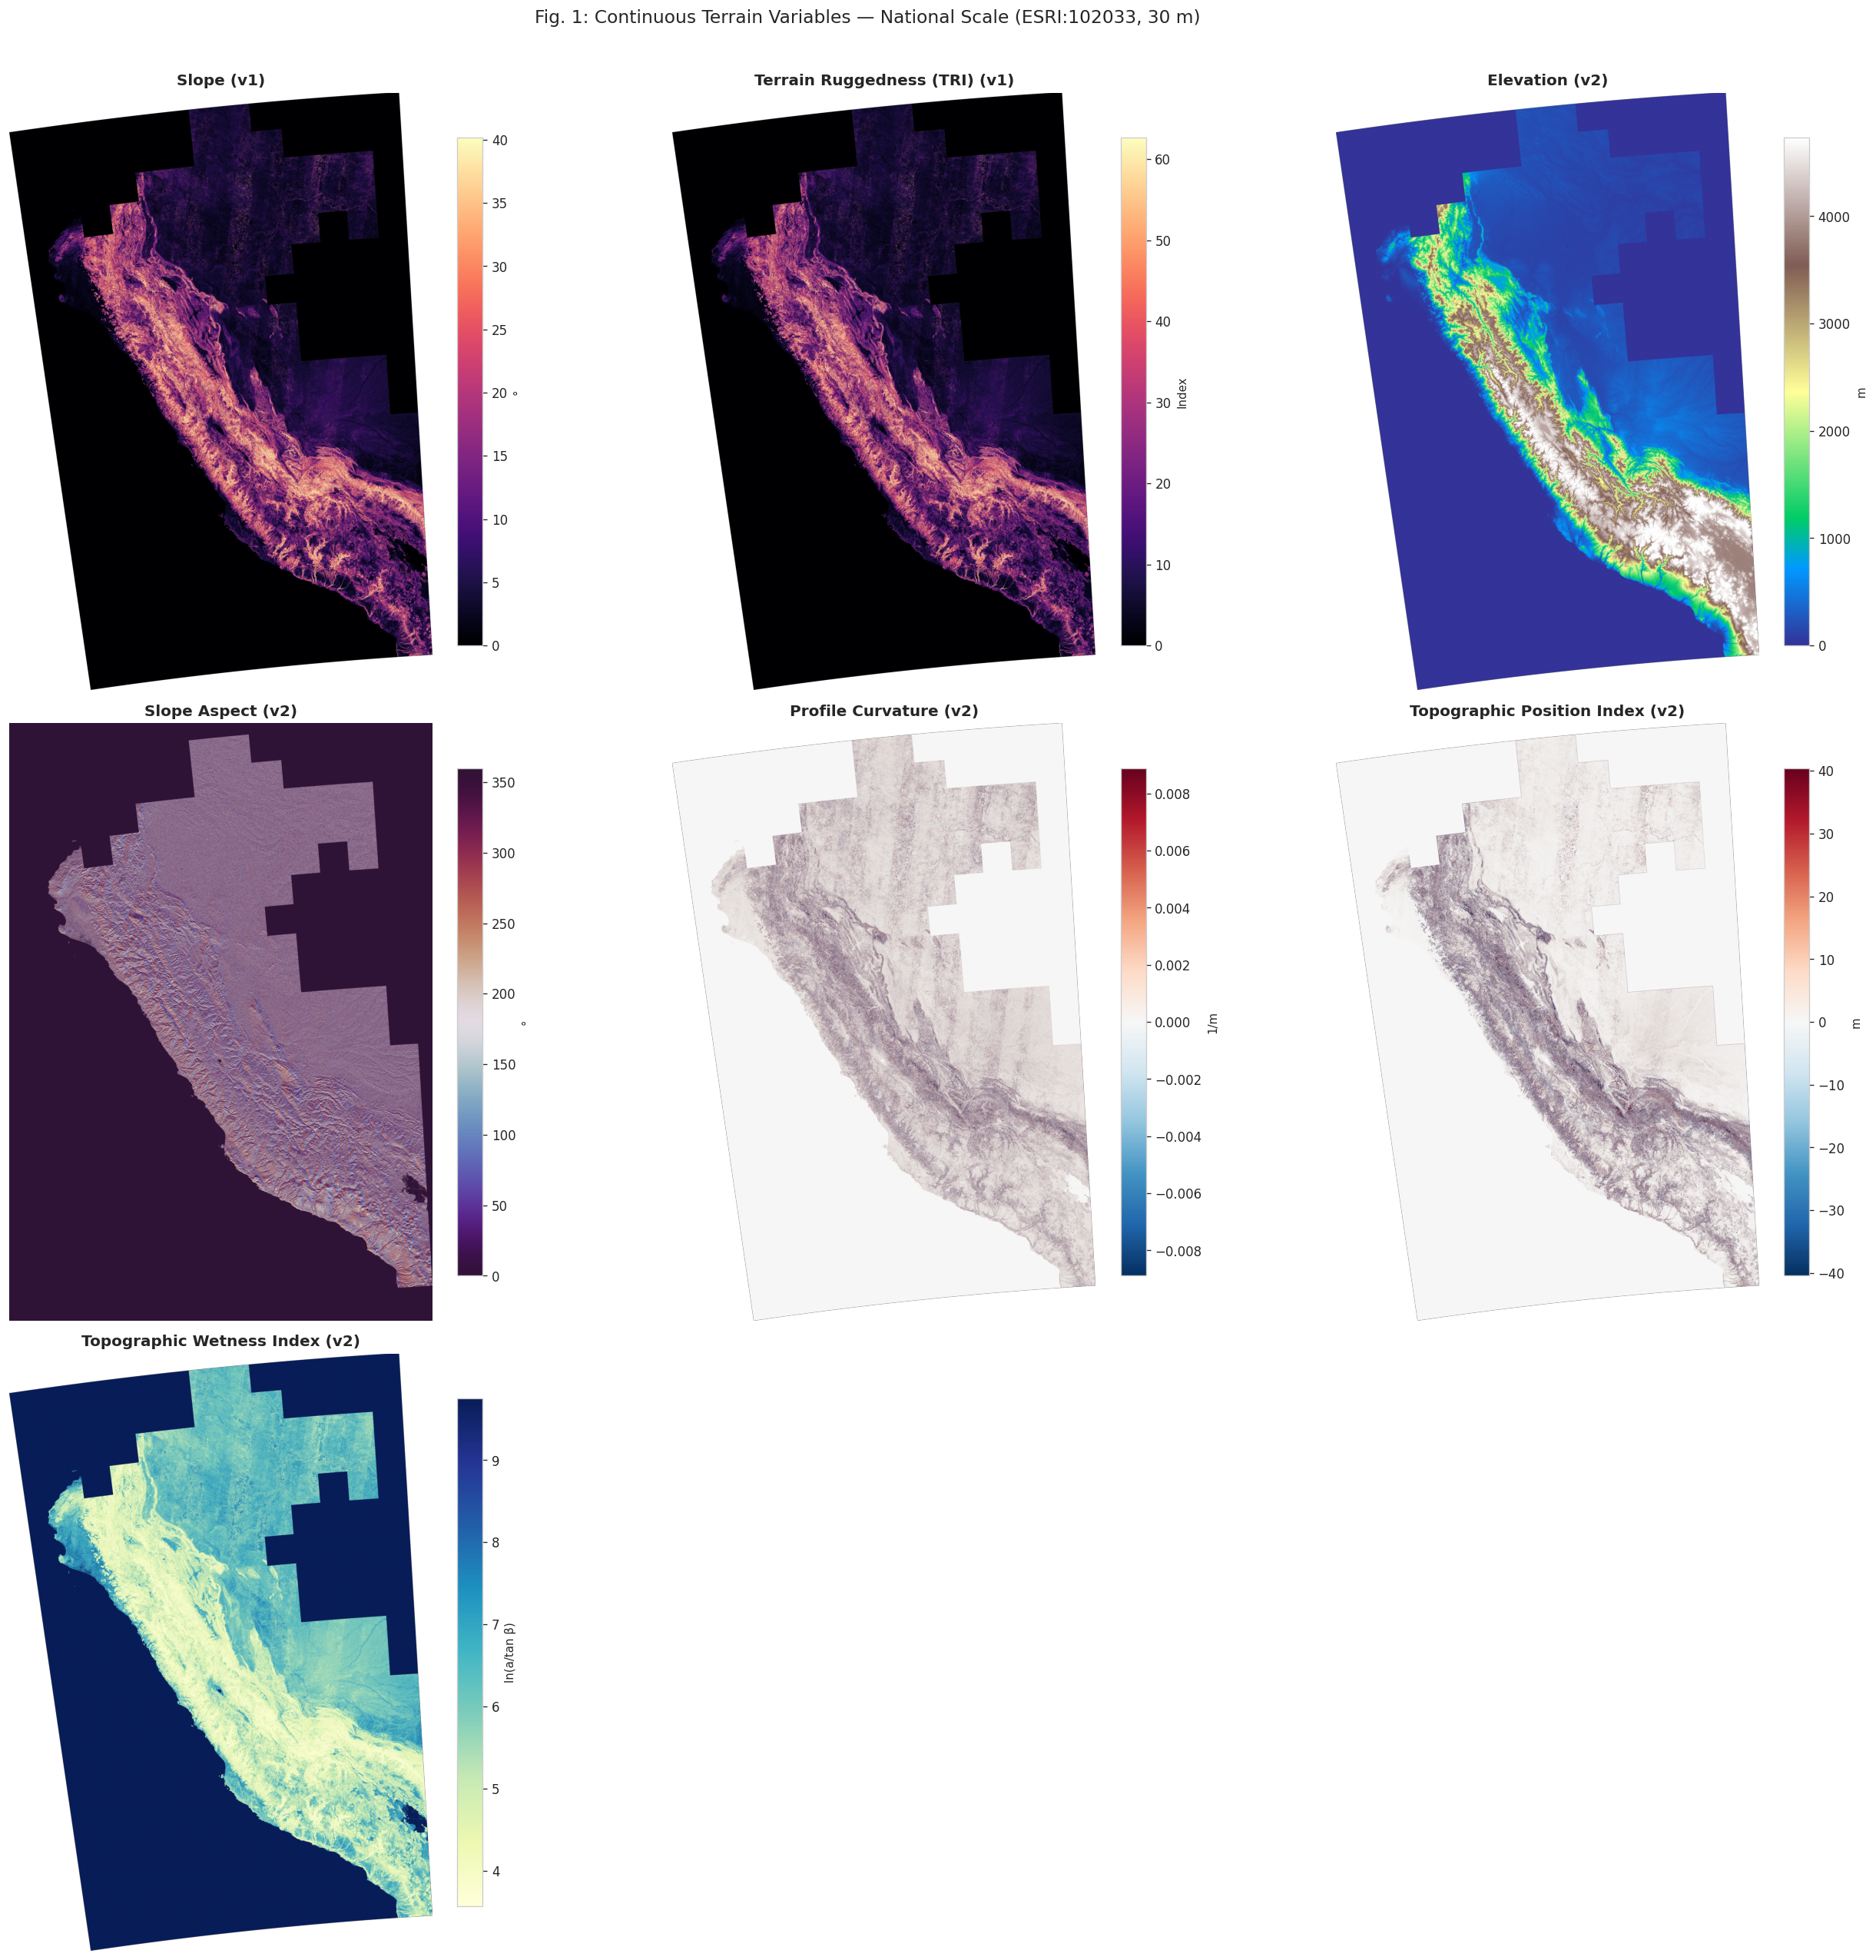

Saved → /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/01_validation/fig_terrain_continuous.png


In [ ]:
# -- Continuous terrain layers (auto-generated from config) --------------------
terrain_cont = [rv for rv in CONT_VARS if rv.group == VarGroup.TERRAIN]

n_panels = len(terrain_cont)
ncols = 3
nrows = (n_panels + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(22, 7 * nrows), dpi=120)
axes = np.atleast_2d(axes).flatten()

for i, rv in enumerate(terrain_cont):
    with rasterio.open(rv.path) as src:
        data = src.read(
            1, out_shape=(1, src.height // DOWNSAMPLE, src.width // DOWNSAMPLE)
        ).astype("float32")
        nodata = src.nodata

    if nodata is not None:
        data[data == nodata] = np.nan

    v_lo = rv.vmin if rv.vmin is not None else np.nanpercentile(data, 1)
    v_hi = rv.vmax if rv.vmax is not None else np.nanpercentile(data, 99)

    if rv.symmetric:
        v_abs = max(abs(v_lo), abs(v_hi))
        v_lo, v_hi = -v_abs, v_abs

    im = axes[i].imshow(data, cmap=rv.cmap, vmin=v_lo, vmax=v_hi)
    cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, shrink=0.85)
    cbar.set_label(rv.unit, fontsize=9)
    axes[i].set_title(f"{rv.label} ({rv.version})", fontsize=12, fontweight="bold")
    axes[i].axis("off")

# Turn off unused subplots
for j in range(n_panels, len(axes)):
    axes[j].axis("off")

fig.suptitle(
    f"Fig. 1: Continuous Terrain Variables -- National Scale ({CRS}, {PIXEL_SIZE} m)",
    fontsize=14, y=1.01,
)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_terrain_continuous.png"), dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR}/fig_terrain_continuous.png")

### **4. Visual Validation — Distance Layers**

Euclidean distances to hydrological and cultural features.  Dark tones indicate immediate nearness, facilitating identification of high-connectivity zones.

**What to look for:**
- Zero-distance pixels tracing the expected source geometries (rivers, roads, sites).
- Smooth distance gradients without abrupt discontinuities.
- Consistent NoData mask across all layers.

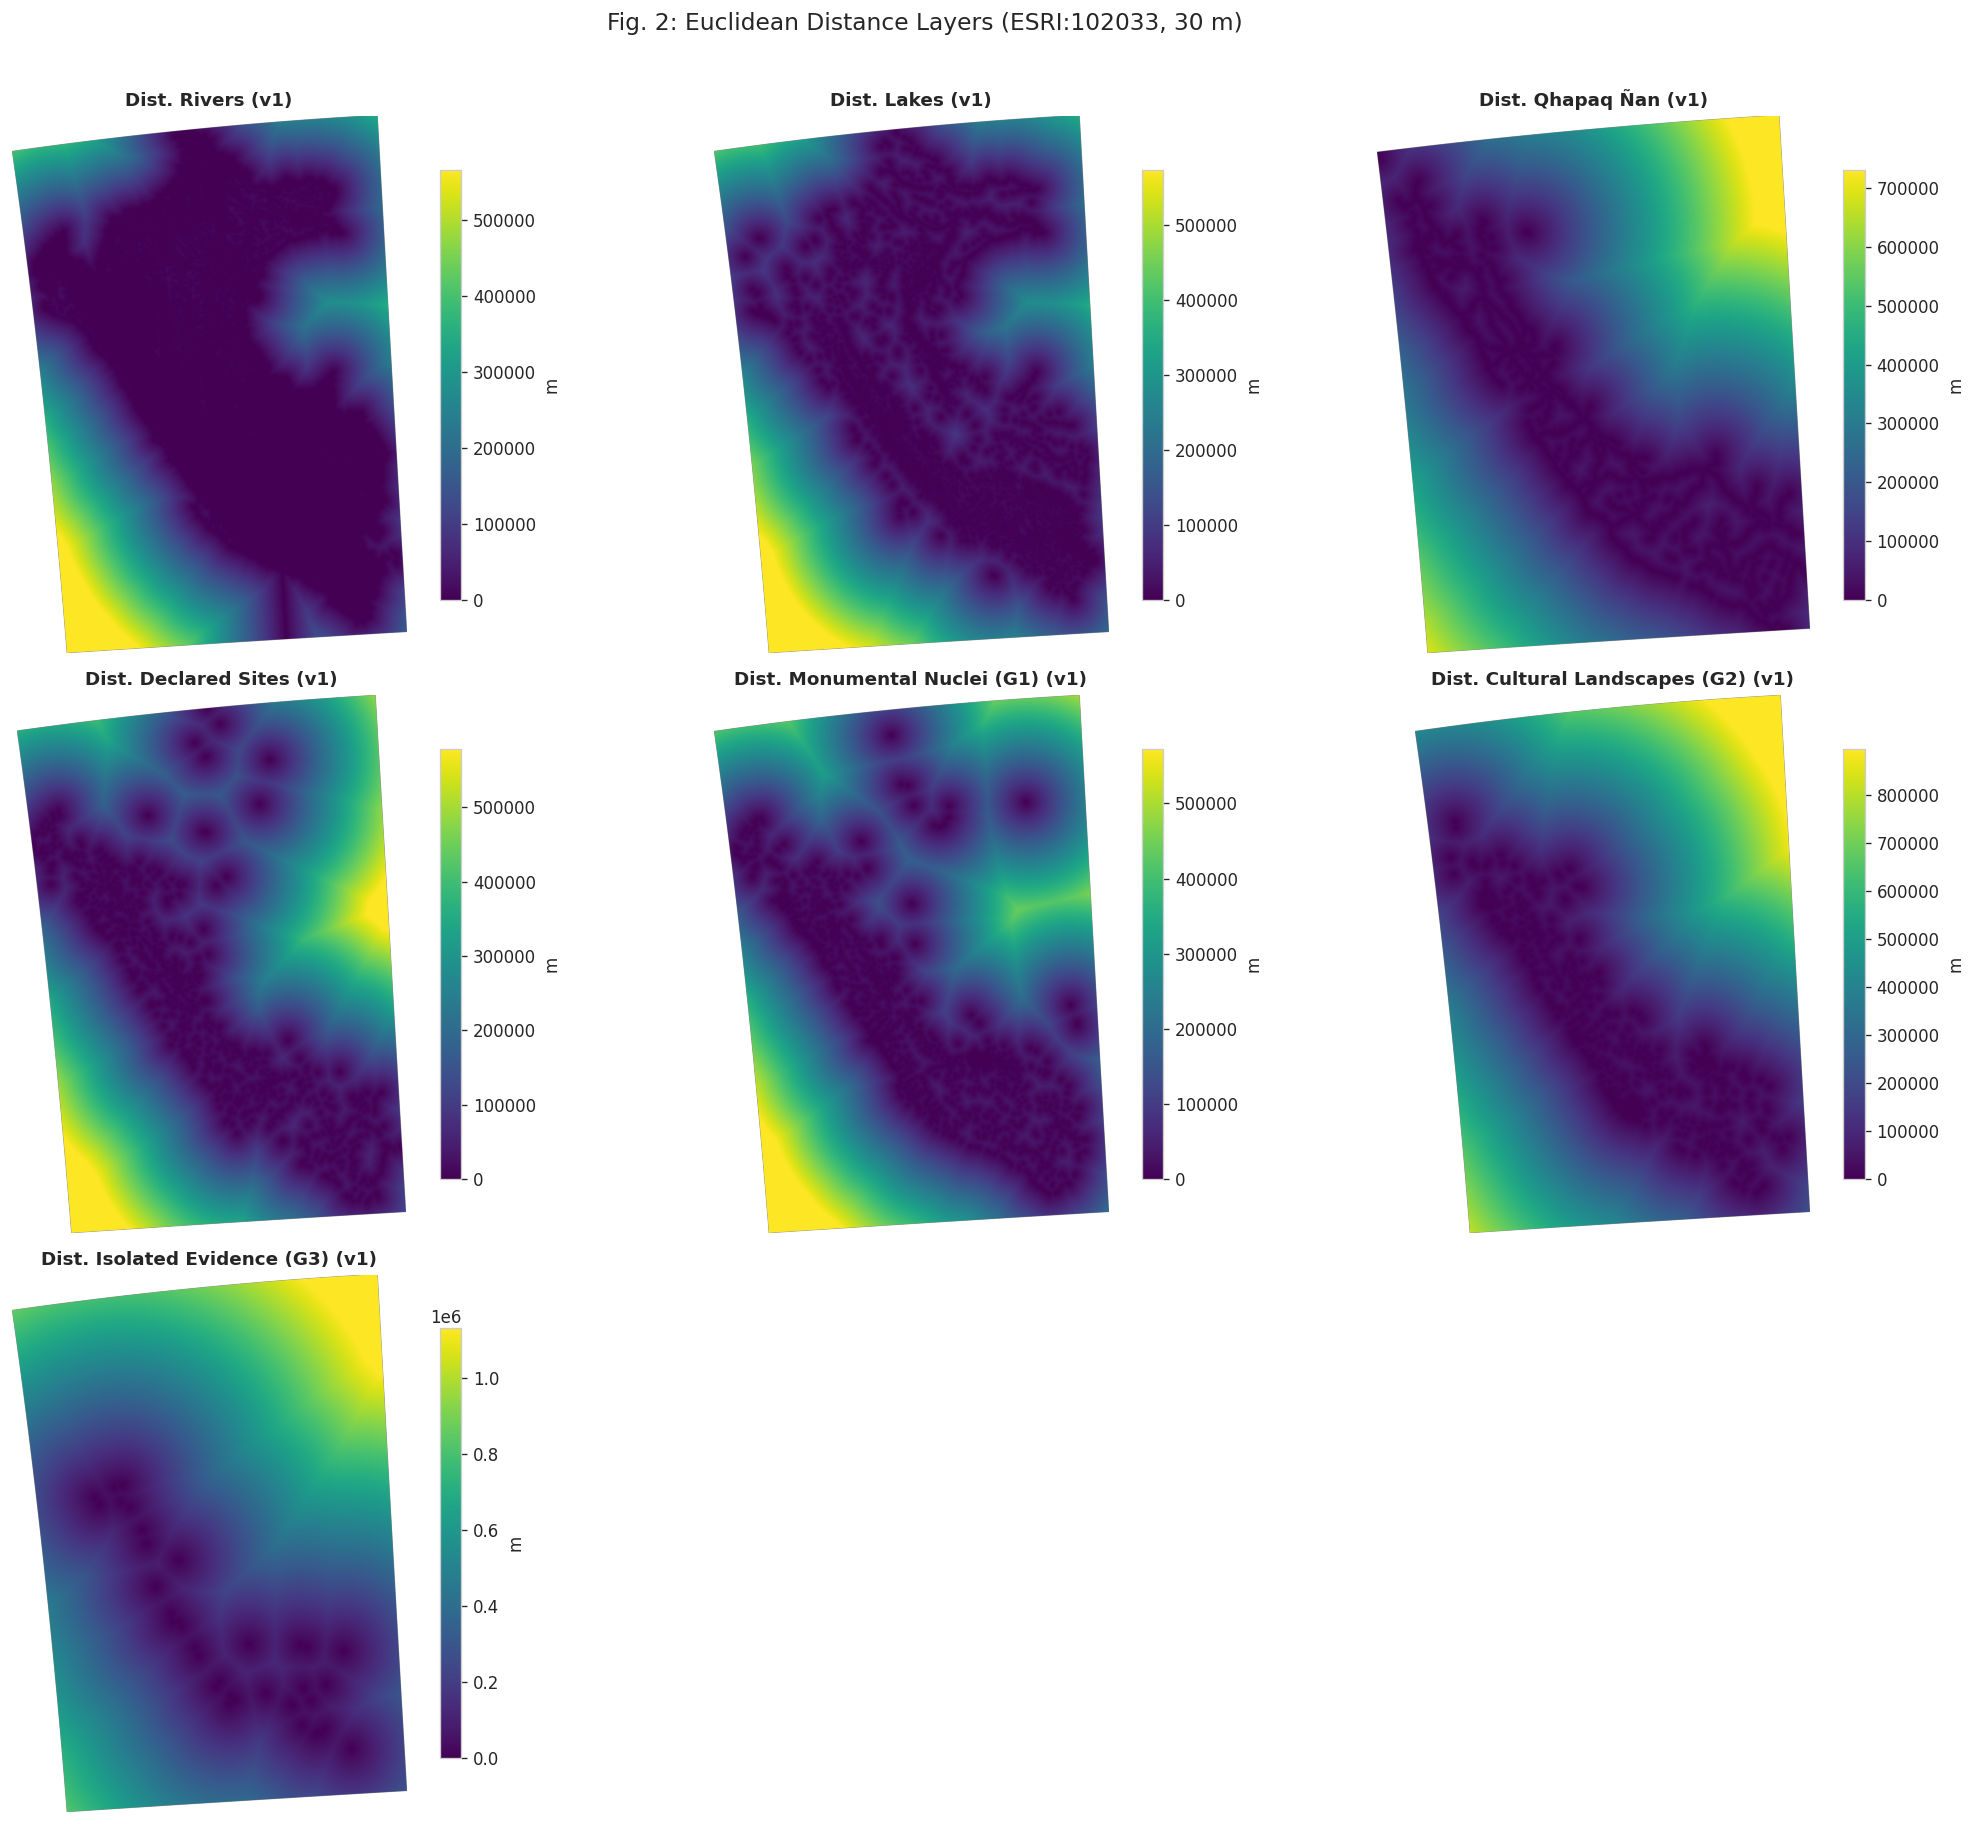

Saved → /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/01_validation/fig_distance_layers.png


In [ ]:
# -- Distance layers (auto-generated from config) -----------------------------
n_dist = len(DIST_VARS)
ncols_d = 3
nrows_d = (n_dist + ncols_d - 1) // ncols_d

fig, axes = plt.subplots(nrows_d, ncols_d, figsize=(18, 5 * nrows_d), dpi=120)
axes = np.atleast_2d(axes).flatten()

for i, rv in enumerate(DIST_VARS):
    with rasterio.open(rv.path) as src:
        data = src.read(
            1, out_shape=(1, src.height // DOWNSAMPLE, src.width // DOWNSAMPLE)
        ).astype("float32")
        nodata = src.nodata

    if nodata is not None:
        data[data == nodata] = np.nan

    v_max = np.nanpercentile(data, 98)

    im = axes[i].imshow(data, cmap=rv.cmap, vmax=v_max)
    fig.colorbar(im, ax=axes[i], label=rv.unit, shrink=0.8)
    axes[i].set_title(f"{rv.label} ({rv.version})", fontsize=11, fontweight="bold")
    axes[i].axis("off")

for j in range(n_dist, len(axes)):
    axes[j].axis("off")

fig.suptitle(
    f"Fig. 2: Euclidean Distance Layers ({CRS}, {PIXEL_SIZE} m)",
    fontsize=14, y=1.01,
)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_distance_layers.png"), dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR}/fig_distance_layers.png")

### **5. Visual Validation — Categorical Variables**

Categorical layers require discrete colourmaps with a legend rather than a continuous colorbar.  The colour mapping and labels are read directly from `config.py`.

**What to look for (Pisos Ecológicos):**
- Bands should follow elevation contours smoothly.
- Coastal zone (Chala) restricted to the western strip below 500 m.
- High-altitude zones (Puna, Janca) visible in the Andes.

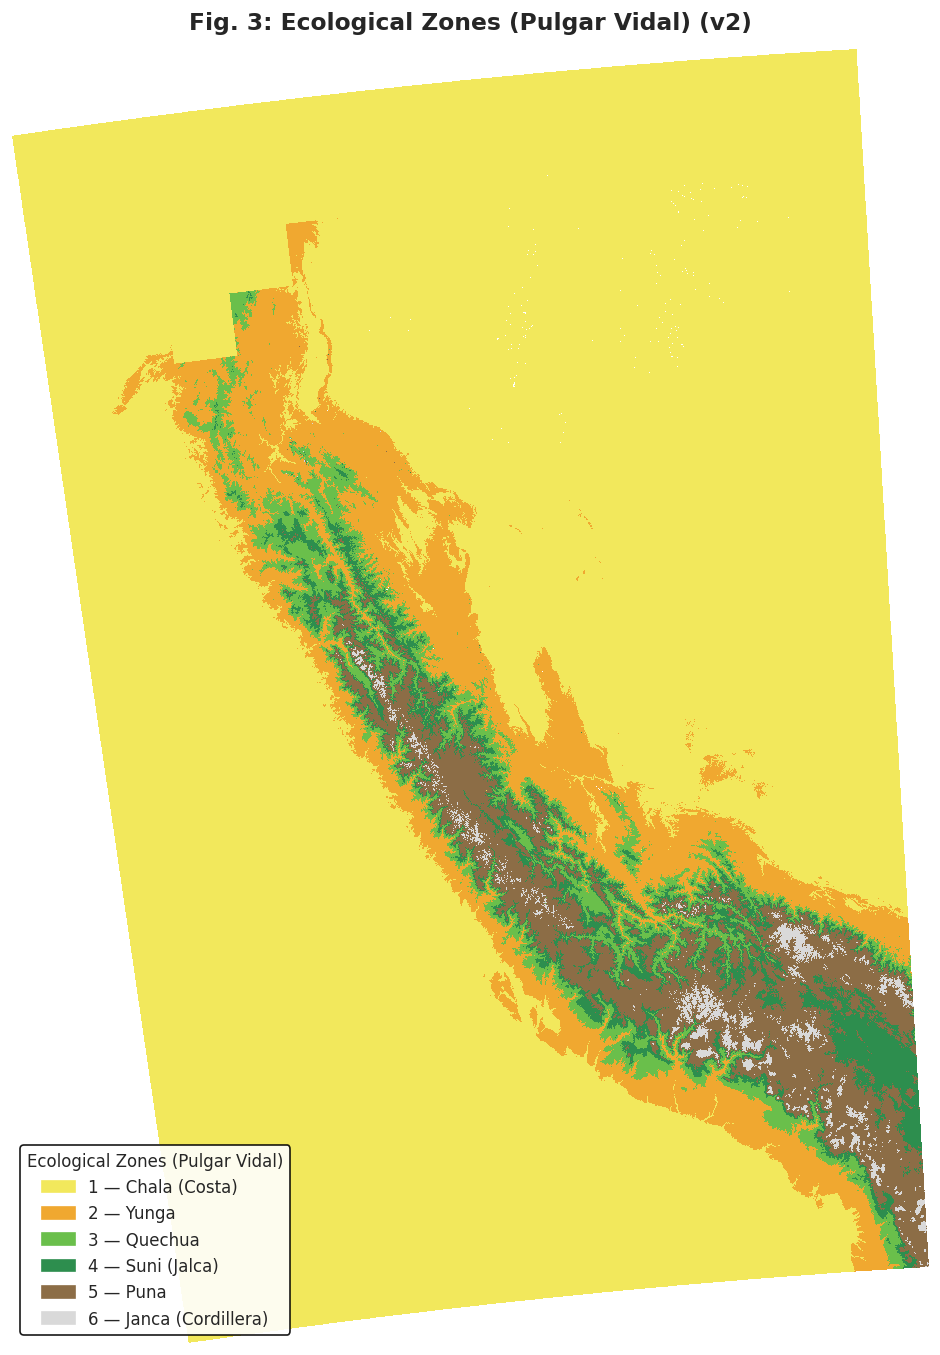

Saved → /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/01_validation/fig_categorical_pisos_ecologicos.png


In [ ]:
# -- Categorical layers (auto-generated from config) --------------------------
for idx, rv in enumerate(CAT_VARS):
    with rasterio.open(rv.path) as src:
        data = src.read(
            1, out_shape=(1, src.height // DOWNSAMPLE, src.width // DOWNSAMPLE)
        ).astype("float32")
        nodata = src.nodata

    if nodata is not None:
        data[data == nodata] = np.nan

    codes  = sorted(rv.cat_labels.keys())
    colors = [rv.cat_colors[c] for c in codes]
    cmap_cat = mcolors.ListedColormap(colors)
    bounds   = [c - 0.5 for c in codes] + [codes[-1] + 0.5]
    norm_cat = mcolors.BoundaryNorm(bounds, cmap_cat.N)

    fig, ax = plt.subplots(figsize=(10, 14), dpi=120)
    im = ax.imshow(data, cmap=cmap_cat, norm=norm_cat, interpolation="nearest")
    ax.axis("off")
    ax.set_title(
        f"Fig. {3 + idx}: {rv.label} ({rv.version})",
        fontsize=14, fontweight="bold", pad=12,
    )

    patches = [
        mpatches.Patch(color=rv.cat_colors[c], label=f"{c} - {rv.cat_labels[c]}")
        for c in codes
    ]
    ax.legend(
        handles=patches, loc="lower left", fontsize=10,
        frameon=True, framealpha=0.9, edgecolor="black", title=rv.label,
    )

    fname = f"fig_categorical_{rv.name}.png"
    fig.savefig(os.path.join(FIGURES_DIR, fname), dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {FIGURES_DIR}/{fname}")

### **6. Descriptive Statistics & Distribution Analysis**

Histograms and summary statistics for every continuous and distance layer.  This cell flags potential issues:
- **Constant bands** (std ~ 0) -- computation error.
- **Extreme skewness** -- may need transformation before modelling.
- **Excessive NoData** (> 50%) -- data coverage gap.

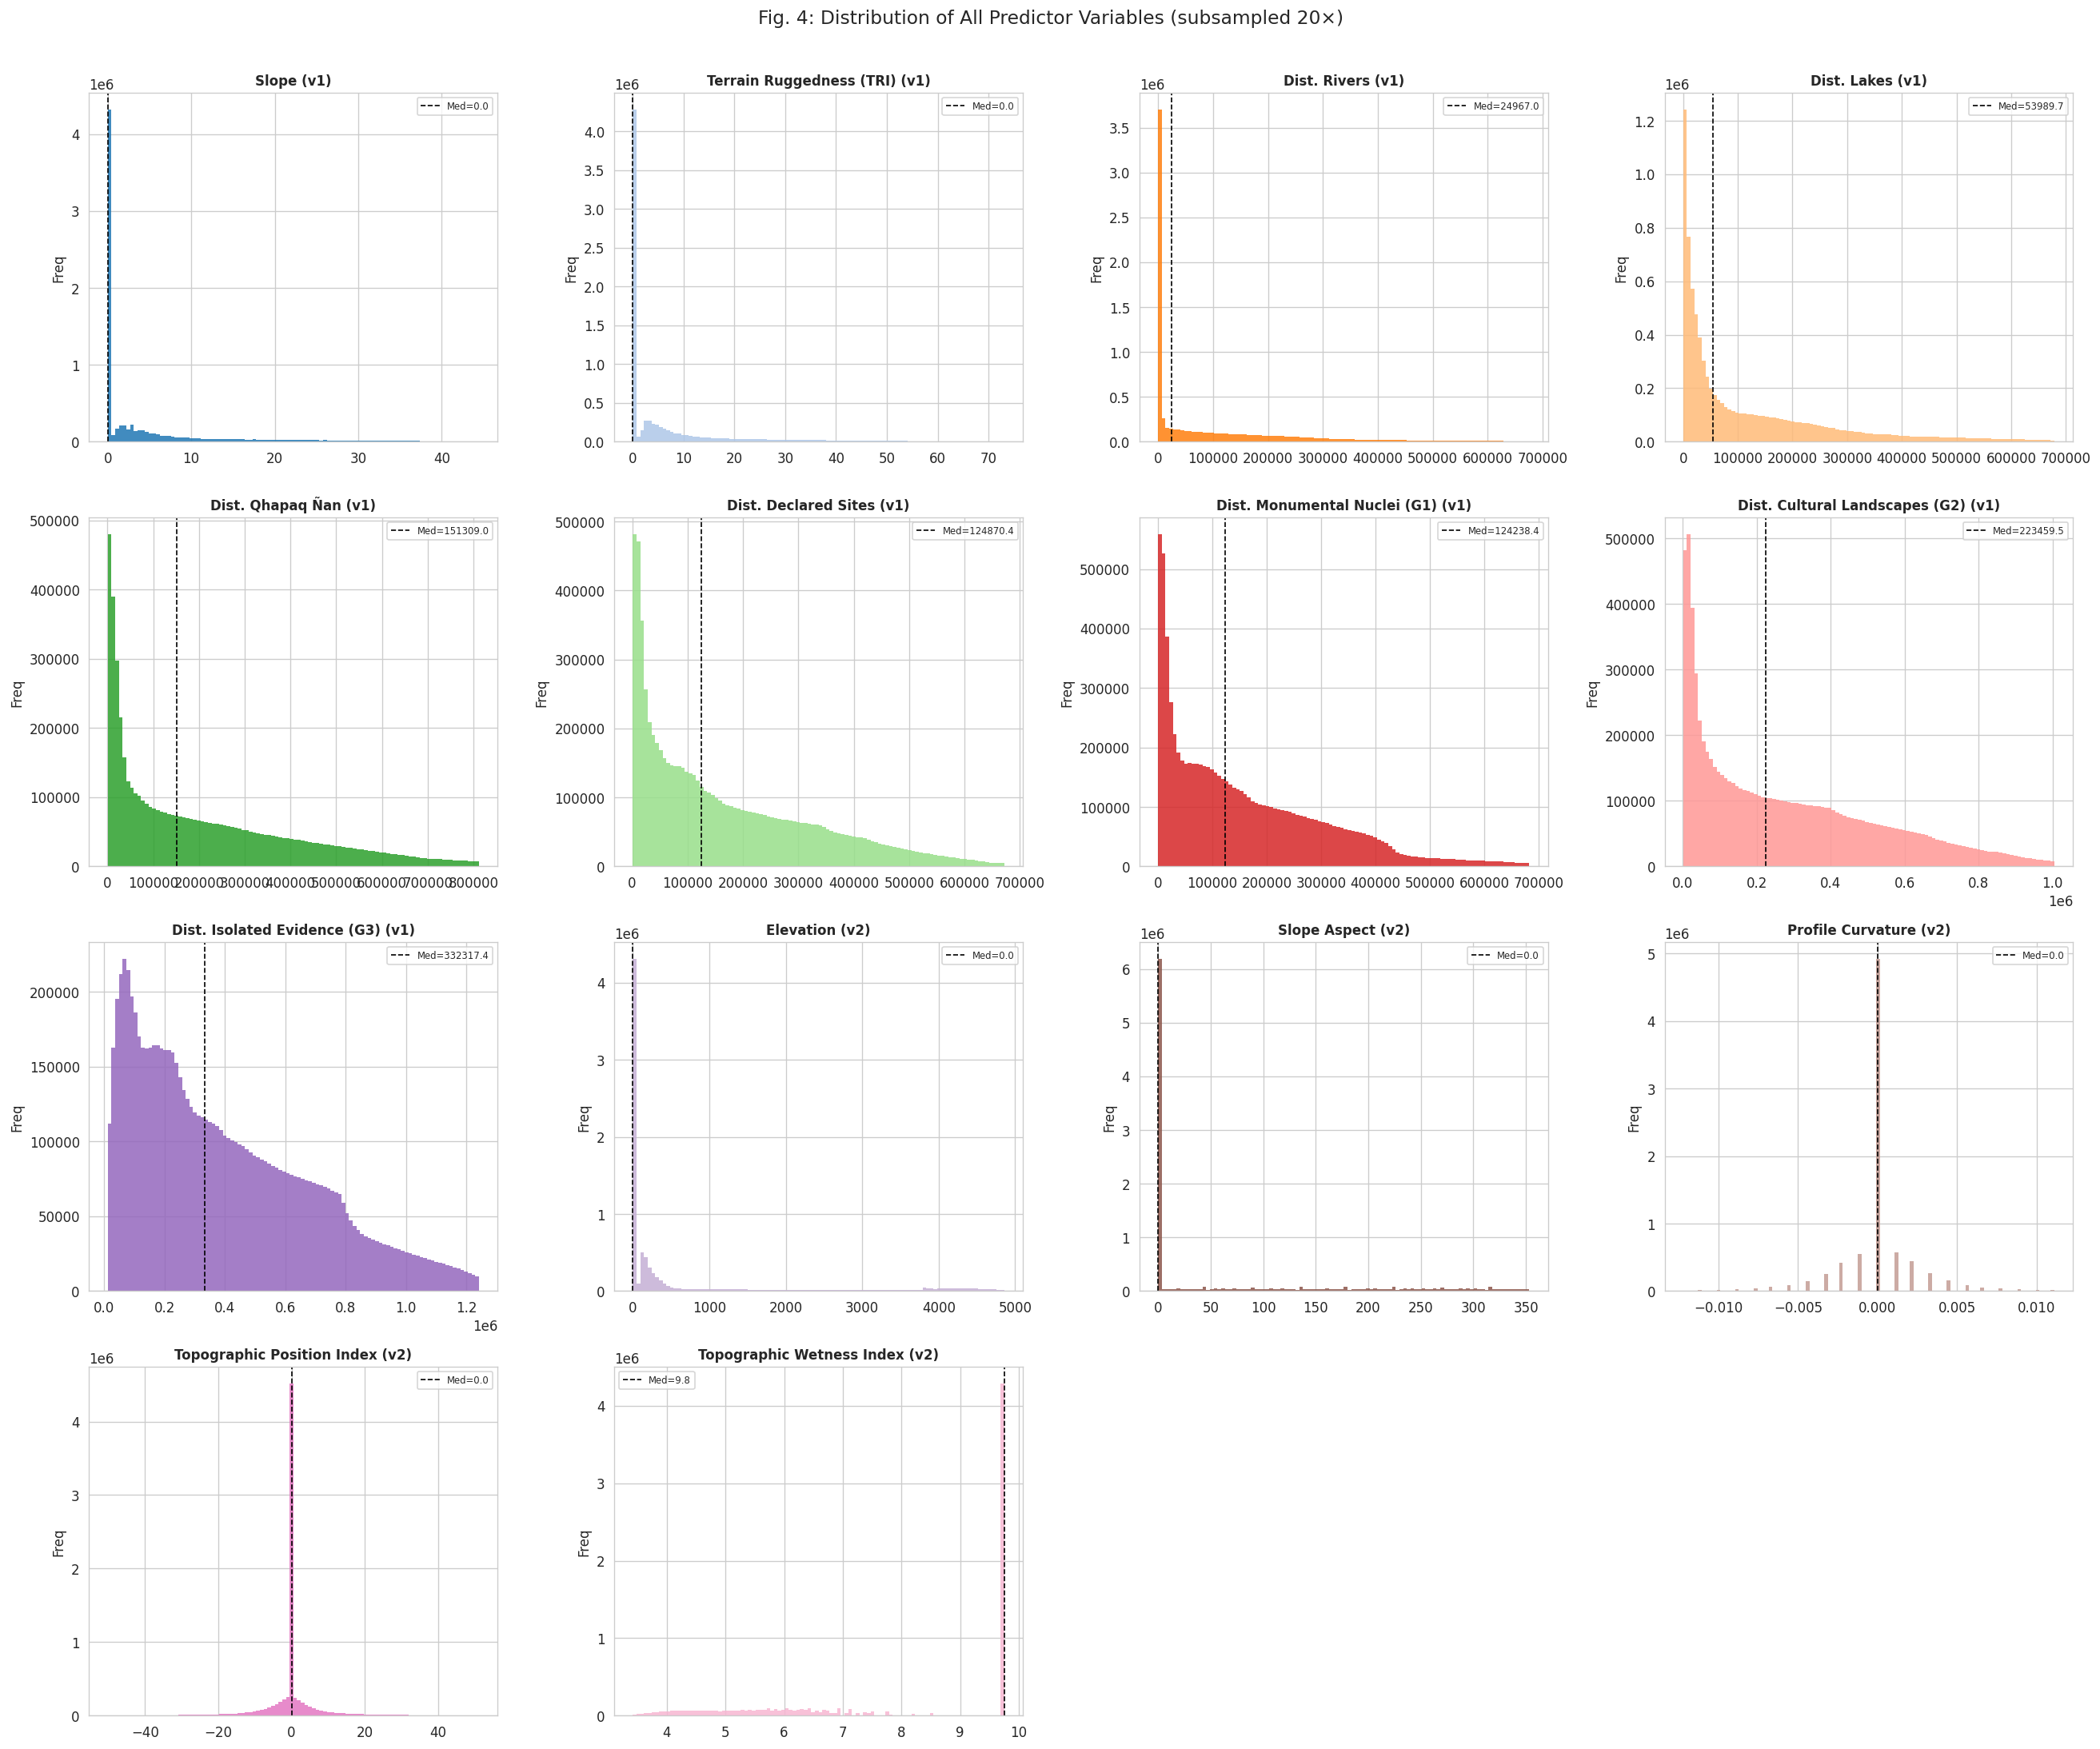


── Summary Statistics ──
          Layer Version    Count NoData %       Min        P5     Median       Mean        P95         Max        Std
      pendiente      v1  8291012     18.1     0.000     0.000      0.000      5.377     27.893      88.966      9.549
      rugosidad      v1  8291012     18.1     0.000     0.000      0.000      8.143     39.433    4987.992     26.308
      dist_rios      v1  8443563     15.1     0.000   108.167  24967.014 103927.431 440334.384  796135.625 149506.532
     dist_lagos      v1  8443563     15.1     0.000  1860.242  53989.707 121674.371 455712.762  798660.125 149210.626
    dist_qhapaq      v1  5597971     14.1     0.000  4484.573 151309.016 212751.444 629492.438  882186.375 205252.450
dist_declarados      v1  7641996     15.2     0.000  6045.502 124870.422 174355.557 494567.562  777172.812 160449.496
        dist_g1      v1  8443563     15.1     0.000  5300.840 124238.438 165108.609 449558.856  803076.688 150539.736
        dist_g2      v1  84435

In [ ]:
 # -- Descriptive statistics + histograms (all non-categorical layers) ----------
numeric_vars = [rv for rv in ALL_VARS if rv.var_type != VarType.CATEGORICAL]
n_num = len(numeric_vars)
ncols_h = 4
nrows_h = (n_num + ncols_h - 1) // ncols_h

fig, axes = plt.subplots(nrows_h, ncols_h, figsize=(22, 4.5 * nrows_h), dpi=120)
axes = np.atleast_2d(axes).flatten()

stats_rows = []
palette = plt.cm.tab20.colors  # 20-colour palette for variety

for i, rv in enumerate(numeric_vars):
    with rasterio.open(rv.path) as src:
        data = src.read(1, out_shape=(1, src.height // 20, src.width // 20)).astype("float64")
        nodata = src.nodata
        total_px = data.size

    valid_mask = (data != nodata) if nodata is not None else ~np.isnan(data)
    vals = data[valid_mask]
    n_nodata = total_px - len(vals)
    pct_nodata = 100.0 * n_nodata / total_px

    row = {
        "Layer": rv.name, "Version": rv.version,
        "Count": len(vals),
        "NoData %": f"{pct_nodata:.1f}",
        "Min": f"{np.min(vals):.3f}",
        "P5": f"{np.percentile(vals,     5):.3f}",
        "Median": f"{np.median(vals):.3f}",
        "Mean": f"{np.mean(vals):.3f}",
        "P95": f"{np.percentile(vals, 95):.3f}",
        "Max": f"{np.max(vals):.3f}",
        "Std": f"{np.std(vals):.3f}",
    }
    stats_rows.append(row)

    lo, hi = np.percentile(vals, [0.5, 99.5])
    color = palette[i % len(palette)]
    axes[i].hist(vals[(vals >= lo) & (vals <= hi)], bins=100, color=color, alpha=0.85, edgecolor="none")
    axes[i].set_title(f"{rv.label} ({rv.version})", fontsize=10, fontweight="bold")
    axes[i].set_ylabel("Freq")
    axes[i].axvline(np.median(vals), color="black", ls="--", lw=1,
                    label=f"Med={np.median(vals):.1f}")
    axes[i].legend(fontsize=7)

for j in range(n_num, len(axes)):
    axes[j].axis("off")

fig.suptitle(
    f"Fig. 4: Distribution of All Predictor Variables (subsampled 20x)",
    fontsize=14, y=1.01,
)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_distributions_all.png"), dpi=150, bbox_inches="tight")
plt.show()

# Summary table
df_stats = pd.DataFrame(stats_rows)
print("\n-- Summary Statistics --")
print(df_stats.to_string(index=False))

# Warnings
for _, r in df_stats.iterrows():
    if float(r["Std"]) < 1e-6:
        print(f"  WARNING: {r['Layer']}: near-constant values (std ~ 0)")
    if float(r["NoData %"]) > 50:
        print(f"  WARNING: {r['Layer']}: excessive NoData ({r['NoData %']}%)")

### **7. Categorical Class Distribution**

Bar chart of pixel counts per class for each categorical variable.  This confirms that reclassification produces reasonable proportions.

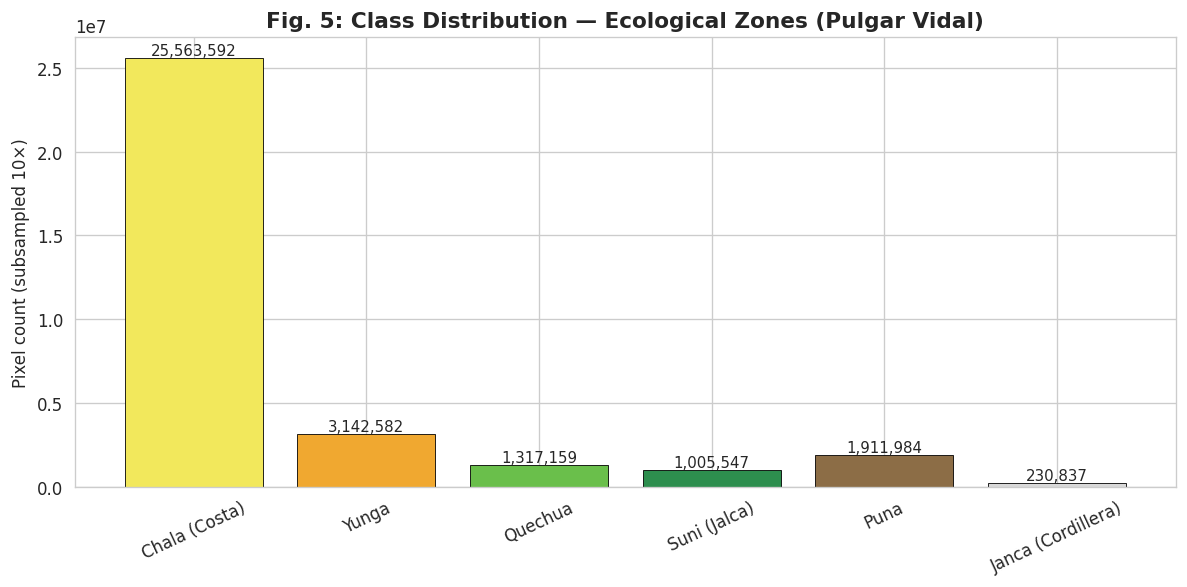

Saved → /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/01_validation/fig_class_distribution_pisos_ecologicos.png


In [ ]:
# -- Categorical class distributions (auto from config) ------------------------
for rv in CAT_VARS:
    with rasterio.open(rv.path) as src:
        data = src.read(1, out_shape=(1, src.height // 10, src.width // 10))
        nodata = src.nodata

    if nodata is not None:
        data = data[data != nodata]
    data = data[~np.isnan(data.astype("float32"))].astype(int)

    unique, counts = np.unique(data, return_counts=True)

    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    bar_colors = [rv.cat_colors.get(u, "#888888") for u in unique]
    bars = ax.bar(
        [rv.cat_labels.get(u, f"Code {u}") for u in unique],
        counts, color=bar_colors, edgecolor="black", linewidth=0.5,
    )

    for bar, cnt in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{cnt:,}", ha="center", va="bottom", fontsize=9)

    ax.set_ylabel("Pixel count (subsampled 10x)")
    ax.set_title(f"Fig. 5: Class Distribution -- {rv.label}", fontsize=13, fontweight="bold")
    ax.tick_params(axis="x", rotation=25)

    plt.tight_layout()
    fname = f"fig_class_distribution_{rv.name}.png"
    fig.savefig(os.path.join(FIGURES_DIR, fname), dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {FIGURES_DIR}/{fname}")

### **8. Spatial Alignment Verification**

Pixel-level grid alignment test against the reference DEM.

| Check    | Meaning | Severity |
|----------|---------|----------|
| **CRS**  | Same coordinate reference system | **Critical** -- different CRS = wrong coordinates |
| **Res**  | Same pixel size (30 m) | **Critical** -- different resolution = scale mismatch |
| **Transform / Shape** | Same origin + dimensions | **Warning** -- different extent, but `src.sample(coords)` still works via geographic coordinates |

The v1 distance layers were generated from shapefiles with different spatial extents than the DEM, so their grids don't match exactly.  This is **not a blocking issue** because pixel drilling uses geographic coordinate lookup (`rasterio.sample`), which is independent of grid alignment.

### **9. Validation Summary**

If no critical errors (CRS/Res) are found, proceed to **Notebook 02 -- Sampling**.

In [ ]:
# -- Pixel-level alignment check (ALL variables) ------------------------------
with rasterio.open(REF_RASTER) as ref:
    ref_transform = ref.transform
    ref_crs       = ref.crs
    ref_res       = ref.res
    ref_shape     = (ref.height, ref.width)

print(f"Reference DEM transform:\n  {ref_transform}\n")
print(f"{'Layer':<22} {'Ver':>3} {'CRS':>5} {'Res':>5} {'Transform':>11} {'Shape':>7} {'Result':>8}")
print("-" * 70)

n_checked   = 0
n_pass      = 0
n_warn      = 0
n_critical  = 0
warn_layers = []

for rv in ALL_VARS:
    if not rv.exists:
        print(f"{rv.name:<22} {rv.version:>3} {'--':>5} {'--':>5} {'--':>11} {'--':>7} {'SKIP':>8}")
        continue

    n_checked += 1
    with rasterio.open(rv.path) as src:
        c_ok = src.crs == ref_crs
        r_ok = src.res == ref_res
        t_ok = src.transform == ref_transform
        s_ok = (src.height, src.width) == ref_shape

    # Classify result
    if not c_ok or not r_ok:
        result = "CRITICAL"
        n_critical += 1
    elif t_ok and s_ok:
        result = "PASS"
        n_pass += 1
    else:
        result = "WARN"
        n_warn += 1
        warn_layers.append(rv.name)

    sym = lambda ok: "ok" if ok else "X"
    print(f"{rv.name:<22} {rv.version:>3} "
          f"{sym(c_ok):>5} {sym(r_ok):>5} "
          f"{sym(t_ok):>11} {sym(s_ok):>7} "
          f"{result:>8}")

# -- Summary ------------------------------------------------------------------
print()
print("=" * 70)

if n_critical > 0:
    print(f"  FAILED: {n_critical} critical error(s) -- CRS or resolution mismatch.")
    print("  Fix the raster generation scripts and rerun.")
    print("  Do NOT proceed with sampling.")
elif n_warn > 0:
    print(f"  PASSED: {n_pass}/{n_checked} layers are pixel-aligned with the DEM.")
    print(f"  WARN:   {n_warn} layer(s) have different extent (grid origin/shape):")
    print(f"          {', '.join(warn_layers)}")
    print()
    print("  These are v1 distance layers generated from shapefiles with")
    print("  different spatial extents. This is safe because pixel drilling")
    print("  uses geographic coordinate lookup (rasterio.sample), which is")
    print("  independent of grid alignment.")
    print()
    print("  OK to proceed with Notebook 02 (Sampling).")
else:
    print(f"  PASSED: All {n_checked} layers are pixel-aligned with the reference DEM.")
    print("  OK to proceed with Notebook 02 (Sampling).")

print("=" * 70)

Reference DEM transform:
  | 30.00, 0.00,-2510197.17|
| 0.00,-30.00, 3622394.82|
| 0.00, 0.00, 1.00|

Layer                  Ver  Transform   CRS  Shape   Result
──────────────────────────────────────────────────────────────
pendiente               v1          ✓     ✓      ✓     PASS
rugosidad               v1          ✓     ✓      ✓     PASS
dist_rios               v1          ✗     ✓      ✗     FAIL
dist_lagos              v1          ✗     ✓      ✗     FAIL
dist_qhapaq             v1          ✗     ✓      ✗     FAIL
dist_declarados         v1          ✗     ✓      ✗     FAIL
dist_g1                 v1          ✗     ✓      ✗     FAIL
dist_g2                 v1          ✗     ✓      ✗     FAIL
dist_g3                 v1          ✗     ✓      ✗     FAIL
altitud                 v2          ✓     ✓      ✓     PASS
aspecto                 v2          ✓     ✓      ✓     PASS
curvatura               v2          ✓     ✓      ✓     PASS
tpi                     v2          ✓     ✓      ✓     